In [1]:
import numpy as np
from scipy import optimize as optimize
import matplotlib.pyplot as plt
import time

## Exercise 2.1

In [2]:
# wage, rent, utility and derivative of utility

def get_L(nvec):
    return np.sum(np.array(nvec))

def get_K(bvec):
    return np.sum(np.array(bvec))

def get_w(nvec, bvec, params):
    A, α = params
    w = (1-α) * A * (get_K(bvec)/get_L(nvec))**α
    return w

def get_r(nvec, bvec, params):
    A, α, δ = params
    r = α * A * (get_L(nvec)/get_K(bvec))**(1-α) - δ
    return r

def get_u(c, params):
    σ = params
    u = (c**(1-σ) - 1) / (1 - σ)
    return u

def get_uprime(c, params):
    σ = params
    mu = c**(-σ)
    return mu

def get_Y(nvec, bvec, params):
    A, α = params
    L = get_L(nvec)
    K = get_K(bvec)
    Y = A * K**α * L**(1 - α)
    return Y

def get_c(nvec, bvec, params):
    A, α, δ = params
    
    n1, n2, n3 = nvec
    b2, b3 = bvec
    w_params = A, α
    r_params = A, α, δ
    
    w = get_w(nvec, bvec, w_params)
    r = get_r(nvec, bvec, r_params)
    
    c1 = n1 * w - b2
    c2 = n2 * w + (1 + r) * b2 - b3
    c3 = (1 + r) * b3 + n3 * w
    
    return c1, c2, c3

In [3]:
def feasible(f_params, bvec_guess):
    b_cnstr = np.full(2, False)
    c_cnstr = np.full(3, False)
    K_cnstr = np.full(1, False)
    
    # unpack parameters
    α, β, δ, σ, A = f_params
    
    nvec = (1, 1, 0.2) # use default values as not specified
    w_params = A, α
    r_params = A, α, δ
    c_params = A, α, δ
    
    w = get_w(nvec, bvec_guess, w_params)
    r = get_r(nvec, bvec_guess, r_params)
    
    c = get_c(nvec, bvec_guess, c_params)
    
    for i in range(3):
        if c[i] < 0:
            c_cnstr[i] = True
        else:
            c_cnstr[i] = False
            
    if c_cnstr[0] == True:
        b_cnstr[0] = True
    elif c_cnstr[1] == True:
        b_cnstr = [True, True]
    elif c_cnstr[2] == True:
        b_cnstr[1] = True
    
    if get_K(bvec_guess) > 0:
        K = [True]
    
    return b_cnstr, c_cnstr, K_cnstr

In [4]:
# parameters
def f_params():
    β = 0.442
    δ = 0.6415
    σ = 3
    A = 1
    α = 0.35
    return α, β, δ, σ, A

### 2.1a

In [5]:
feasible(f_params(), [1.0, 1.2])

(array([ True, False]), array([ True, False, False]), array([False]))

Nonnegativity constraint of c1 is violated, likely to be caused by b2

### 2.1b

In [6]:
feasible(f_params(), [0.06, -0.001])

(array([False, False]), array([False, False, False]), array([False]))

No constraint is violated

### 2.1c

In [7]:
feasible(f_params(), [0.1, 0.1])

(array([False, False]), array([False, False, False]), array([False]))

No constraint is violated

## Exercise 2.2

In [8]:
def eqbm(bvec, w, r, params):

    β, σ, nvec, L, A, α, δ, SS_tol = params
    
    w_params = A, α
    r_params = A, α, δ
    c_params = A, α, δ
    
    w = get_w(nvec, bvec, w_params)
    r = get_r(nvec, bvec, r_params)
    
    c1bar, c2bar, c3bar = get_c(nvec, bvec, c_params)
    
    mu1 = get_uprime(c1bar, σ)
    mu2 = get_uprime(c2bar, σ)
    mu3 = get_uprime(c3bar, σ)
    
    f1 = mu1 - β * (1 + r) * mu2
    f2 = mu2 - β * (1 + r) * mu3

    return f1, f2

In [9]:
def get_SS(params, bvec_guess, SS_graphs = True):
    
    #start time
    start_time = time.time()
    
    #unpack parameters
    β, σ, nvec, L, A, α, δ, SS_tol = params
    
    w_params = A, α
    r_params = A, α, δ
    c_params = A, α, δ
    Y_params = A, α
    
    w = get_w(nvec, bvec_guess, w_params)
    r = get_r(nvec, bvec_guess, r_params)
    
    #find root
    b_ss = optimize.fsolve(eqbm, bvec_guess, args = (w, r, params), xtol = SS_tol)
    b2bar, b3bar = b_ss
    
    #compute all steady state variables
    c_ss = get_c(nvec, b_ss, c_params)
    w_ss = get_w(nvec, b_ss, w_params)
    r_ss = get_r(nvec, b_ss, r_params)
    K_ss = get_K(b_ss)
    Y_ss = get_Y(nvec, b_ss, Y_params)
    C_ss = np.sum(c_ss)
    EulErr_ss = eqbm(b_ss, w_ss, r_ss, params)
    RCerr_ss = Y_ss - C_ss - δ * K_ss
    ss_time = time.time() - start_time
    
    if SS_graphs == True:
        plt.figure(figsize = (7,7))
        plt.plot([2,3], b_ss, '-o', label = 'savings')
        plt.plot([1,2,3], c_ss, '-o', label = 'consumption')
        plt.xlabel('age')
        plt.xticks([1,2,3])
        plt.ylabel('savings and consumption')
        plt.title('savings and consumption vs. age')
        plt.legend()
        plt.grid()
        plt.show()
    
    results = dict({'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss, 
                    'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
                    'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
                    'ss_time': ss_time})
    return results

### 2.2a and b

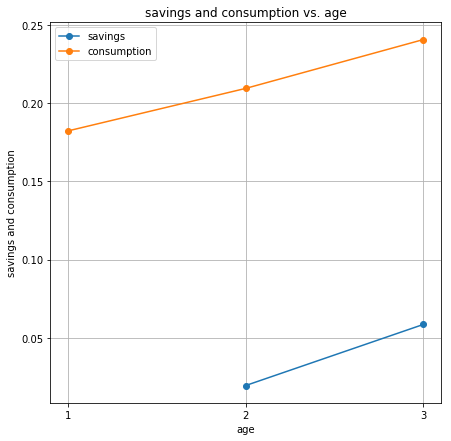

{'b_ss': array([0.01931253, 0.0584111 ]),
 'c_ss': (0.18241212755849867, 0.20961468030898922, 0.24087386507209851),
 'w_ss': 0.20172465739052575,
 'r_ss': 2.433062339127069,
 'K_ss': 0.07772362575316386,
 'Y_ss': 0.6827603788602411,
 'C_ss': 0.6329006729395864,
 'EulErr_ss': (-1.3926637620897964e-12, 2.6290081223123707e-12),
 'RCerr_ss': 8.326672684688674e-17,
 'ss_time': 0.0027589797973632812}

In [10]:
def params1():
    β = 0.442
    δ = 0.6415
    σ = 3
    A = 1
    α = 0.35
    nvec = np.array([1, 1, 0.2])
    L = np.sum(nvec)
    SS_tol = 1e-8
    return β, σ, nvec, L, A, α, δ, SS_tol

bvec_guess = [0.1, 0.1]

ss1 = get_SS(params1(), bvec_guess)
ss1

### 2.2c

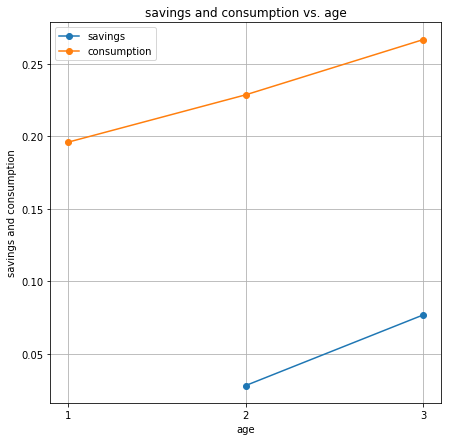

{'b_ss': array([0.02817692, 0.07686545]),
 'c_ss': (0.19597527701928497, 0.2286159413839988, 0.26669307195186887),
 'w_ss': 0.22415219593446706,
 'r_ss': 1.8863765057189819,
 'K_ss': 0.1050423702259807,
 'Y_ss': 0.7586689708551193,
 'C_ss': 0.6912842903551526,
 'EulErr_ss': (6.87805368215777e-12, 2.5295321393059567e-12),
 'RCerr_ss': 9.71445146547012e-17,
 'ss_time': 0.0014562606811523438}

In [11]:
def params2():
    β = 0.55
    δ = 0.6415
    σ = 3
    A = 1
    α = 0.35
    nvec = np.array([1, 1, 0.2])
    L = np.sum(nvec)
    SS_tol = 1e-8
    return β, σ, nvec, L, A, α, δ, SS_tol

bvec_guess = [0.1, 0.1]

ss2 = get_SS(params2(), bvec_guess)
ss2

In [12]:
difference = ss1
for i in ss1.keys():
    difference[i] = np.array(ss2[i]) - np.array(ss1[i])
difference

{'b_ss': array([0.00886439, 0.01845436]),
 'c_ss': array([0.01356315, 0.01900126, 0.02581921]),
 'w_ss': 0.022427538543941306,
 'r_ss': -0.5466858334080873,
 'K_ss': 0.027318744472816847,
 'Y_ss': 0.0759085919948782,
 'C_ss': 0.05838361741556619,
 'EulErr_ss': array([ 8.27071744e-12, -9.94759830e-14]),
 'RCerr_ss': 1.3877787807814457e-17,
 'ss_time': -0.0013027191162109375}

Everything increases except rent.  
This can be interpreted as ...  
I think that the exogenous labour supply plays a part...

## Exercise 2.3
Time path iteration:  
- Step 1: solve for steady state, finished in 2.2
- Step 2: guess $T = 50$
- Step 3: guess 
$$K^i = (K_1^i, ... , K_T^i) = (1, ..., 1)$$
$$r^i = (r_1^i, ... , r_T^i) = (1, ..., 1)$$
$$w^i = (w_1^i, ... , w_T^i) = (1, ..., 1)$$
- Step 4: Solve household problem, solution as $(b_{2, t+1}, b_{3, t+1})_{t=1}^T$
- Step 5: update capital stock, check $\sum||K^{i'}-K^i|| \leq \epsilon$, if not, update $K^{i+1} = \xi K^{i'} + (1-\xi) K^i$

In [13]:
# Step 1:
b_ss = ss1['b_ss']
K_ss = ss1['K_ss']
r_ss = ss1['r_ss']
w_ss = ss1['w_ss']

In [14]:
# Step 2:
def guessT():
    return 50

In [27]:
# Step 3:
def guessK(T, b_init):
    
    K0 = get_K(b_init)
    K_init = np.linspace(K0, K_ss, T)

    return K_init

def get_w_with_K(K, L, params):
    
    # unpack params
    β, σ, nvec, L, A, α, δ, SS_tol = params
    
    w = (1-α) * A * (K/L)**α
    
    return w

def get_r_with_K(K, L, params):
    
    # unpack params
    β, σ, nvec, L, A, α, δ, SS_tol = params
    
    r = α * A * (L/K)**(1-α) - δ
    return r

In [69]:
# Step 4:
def Euler_old(b32, bvec, r1, r2, w1, w2, params):
    
    # unpack params
    β, σ, nvec, L, A, α, δ, SS_tol = params
    b21, b31 = bvec
    n1, n2, n3 = nvec
    
    # marginal utilities
    mu2 = get_uprime(w1 * n2 + (1 + r1) * b21 - b32, α)
    mu3 = get_uprime(w2 * n3 + (1 + r2) * b32, α)
    
    # Euler in the first period, for middle-aged.
    f3 = mu2 - β * (1 + r2) * mu3
        
    return f3

def Euler_young(new_twisted_b, bvec, b32, r3, w3, params):
    
    # unpack params
    b22, b33 = new_twisted_b
    β, σ, nvec, L, A, α, δ, SS_tol = params
    n1, n2, n3 = nvec
    
    # pack params
    w_params = A, α
    r_params = A, α, δ
    
    # w2 and r2
    w1 = get_w(nvec, bvec, w_params)
    w2 = get_w(nvec, [b22, b32], w_params)
    r2 = get_r(nvec, [b22, b32], r_params)
    
    # Euler other than first period, for young-aged.
    mu1 = get_uprime(w1 * n1 - b22, α)
    mu2 = get_uprime(w2 * n2 + (1 + r2) * b22 - b33, α)
    mu3 = get_uprime(w3 * n3 + (1 + r3) * b33, α)
    
    f1 = mu1 - β * (1 + r2) * mu2
    f2 = mu2 - β * (1 + r3) * mu3
    
    return np.array([f1, f2])

def iteration_first(bvec, r1, r2, w1, w2, params):
    # if we are at the very first period
    
    # unpack params
    β, σ, nvec, L, A, α, δ, SS_tol = params
    b32 = bvec[1]
    
    b32 = float(optimize.fsolve(Euler_old, b32, args = (bvec, r1, r2, w1, w2, params), xtol = SS_tol))
    b21 = bvec[0]
    twisted_b = np.array([b21, b32])
    
    return twisted_b

def one_iteration(twisted_b, b31, r3, w3, params):
    # if not at first period
    
    # unpack params
    β, σ, nvec, L, A, α, δ, SS_tol = params
    
    
    b21, b32 = twisted_b
    bvec = np.array([b21, b31])
    new_twisted_b = optimize.fsolve(Euler_young, twisted_b, args = (bvec, b32, r3, w3, params), xtol = SS_tol)
    
    return new_twisted_b

def one_TPI(T, w, r, b_init, K_old, params):
    K_new = np.copy(K_old)
    for i in range(T):
        if i == 0: # in the very first period
            old_twisted_b = iteration_first(b_init, r[0], r[1], w[0], w[1], params)
            b31 = b_init[1]
        # then, in all periods
        new_twisted_b = one_iteration(old_twisted_b, b31, r[i+2], w[i+2], params)
        b_current = [new_twisted_b[0], old_twisted_b[1]]
        print(b_current)
        b31 = b_current[1]
        K_current = get_K(b_current)
        K_new[i] = K_current 
        old_twisted_b = new_twisted_b
        
    return K_new

In [71]:
def l2diff(K_new, K_old):
    K_new = K_new[:50:]
    L_old = K_old[:50:]
    diff = 0.0
    for i in range(len(K_new)):
        norm = (K_new[i] - K_old[i])**2
        diff += norm
    
    diff = np.sqrt(diff)
    return diff

def iterate(T, tol, maxiter, params):
    
    # unpack params
    β, σ, nvec, L, A, α, δ, SS_tol = params
    
    # initialize
    b_init = [0.8 * b_ss[0], 1.1 * b_ss[1]]
    K_init = guessK(T+2, b_init)
    w = get_w_with_K(K_init, L, params)
    r = get_r_with_K(K_init, L, params)
    
    K_new = K_init
    K_old = K_init
    
    diff = np.inf
    i = 0
    while diff > tol:
        print(i)
        K_new = one_TPI(T, w, r, b_init, K_old, params)
        w = get_w_with_K(K_new, L, params)
        r = get_r_with_K(K_new, L, params)
        print(K_old)
        diff = l2diff(K_new, K_old)
        i += 1
        K_old = K_new
        
        if i > maxiter:
            print("did not converge within {} iterations".format(maxiter))
            break
    
    return K_new

In [72]:
iterate(50, 1e-5, 100, params1())

0
[0.03887806847630356, 0.1387725866195722]
[0.03347003415514714, 0.26516668532046717]
[0.041658695109791366, 0.2838868921507683]
[0.03825001366392411, 0.2992884609512053]
[0.04010280709108089, 0.29764466593360017]
[0.03924008016981894, 0.29984384295724203]
[0.039670854118933736, 0.2991076575832416]
[0.03946563574041374, 0.29955219295805446]
[0.03956803350510883, 0.29936532756003587]
[0.03952052303709337, 0.2994720961373011]
[0.03954579944518315, 0.2994330377760006]
[0.03953567419453786, 0.29946415149658334]
[0.03954275349884901, 0.2994609887815917]
[0.03954146893754367, 0.299474450168133]
[0.03954425010473699, 0.2994798224574816]
[0.039545055218972155, 0.29948912556940444]
[0.03954682119125847, 0.2994965182682418]
[0.03954812042887797, 0.29950484030628344]
[0.039549646868734856, 0.29951271139452207]
[0.039551063199604726, 0.2995208024935816]
[0.03955253338239827, 0.29952878746481276]
[0.03955397771930899, 0.29953682483930166]
[0.03955543494956864, 0.2995448375588386]
[0.03955688624314

[0.041947193109712046, 0.1035475593873809]
[0.042093663430992564, 0.10331205843768311]
[0.042016524932000796, 0.10343927900263243]
[0.04205743469887458, 0.10337250509743924]
[0.04203585285528839, 0.10340789296137243]
[0.042047223283125074, 0.10338929569264839]
[0.042041241945722105, 0.10339910163076642]
[0.04204437388680994, 0.10339398473279982]
[0.042042730330282795, 0.10339668659585224]
[0.042043582805119585, 0.10339530154783816]
[0.04204313404230682, 0.10339604705553271]
[0.04204336180252925, 0.10339568486370064]
[0.042043238815777324, 0.10339589696170806]
[0.04204329714969871, 0.10339581217954492]
[0.042043262027407914, 0.10339588041495529]
[0.0420432749259717, 0.10339587002675184]
[0.04204326322738687, 0.10339589991151266]
[0.042043264086321426, 0.10339590923714936]
[0.042043258555411335, 0.10339592902506983]
[0.0420432562641211, 0.10339594350979256]
[0.04204325233582171, 0.10339596067523925]
[0.042043249231113466, 0.10339597649305182]
[0.04204324571320288, 0.10339599298799065]
[0

 0.14000821 0.39400883 0.02732017 0.02731874]
16
[0.03086561764470425, 0.07323550864630109]
[0.042386568257648985, 0.09083391091741595]
[0.04056075378896698, 0.10294456260505908]
[0.042686129865563076, 0.10149083177565023]
[0.04177869872043998, 0.10341151163373465]
[0.04231544176350264, 0.10262696709864218]
[0.042039267700913624, 0.10309876839084839]
[0.042189274717999777, 0.10285764645304865]
[0.042109574162133796, 0.10298894206591257]
[0.04215229337241823, 0.10291925184378391]
[0.042129477432482694, 0.10295661810626411]
[0.04214168024056721, 0.10293666418725882]
[0.04213515764275994, 0.10294733648208831]
[0.04213864472254901, 0.10294163233288321]
[0.04213678071690992, 0.102944681804809]
[0.04213777707092541, 0.10294305189585183]
[0.04213724451995979, 0.10294392314184103]
[0.04213752912363713, 0.10294345758200914]
[0.042137377019997396, 0.10294370644309885]
[0.04213745827841572, 0.10294357353980522]
[0.042137414850318675, 0.10294364461406638]
[0.04213743802400681, 0.1029436067123949]


array([0.1041003 , 0.13321917, 0.14350386, 0.14417548, 0.14518872,
       0.14494092, 0.14513654, 0.14504543, 0.14509702, 0.14507005,
       0.1450846 , 0.14507685, 0.145081  , 0.14507878, 0.14507997,
       0.14507934, 0.14507967, 0.14507949, 0.14507959, 0.14507954,
       0.14507957, 0.14507955, 0.14507956, 0.14507956, 0.14507958,
       0.14507962, 0.14507969, 0.14507979, 0.14507987, 0.14507993,
       0.14507998, 0.14508001, 0.14508003, 0.14508002, 0.14508005,
       0.14508009, 0.14507976, 0.14508053, 0.14508052, 0.14507477,
       0.14509373, 0.14507465, 0.14499526, 0.14539935, 0.14466965,
       0.14404574, 0.15180221, 0.13240736, 0.1400082 , 0.39400885,
       0.02732017, 0.02731874])